In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, classification_report,
    confusion_matrix, precision_score, recall_score
)
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset
df = pd.read_csv('preprocessed_data.csv')

In [4]:
categorical_col = "sSizeID"

# --- Define target and features ---
# Replace 'Defect' with the actual column name of your target
target_col = "iDefect"
X = df.drop(columns=[target_col])
y = df[target_col]

# --- One-hot encode sSizeID ---
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
encoded = encoder.fit_transform(X[[categorical_col]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([categorical_col]))

# --- Replace original sSizeID with encoded columns ---
X = pd.concat([X.drop(columns=[categorical_col]).reset_index(drop=True),
               encoded_df.reset_index(drop=True)], axis=1)

# --- Split into train & test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling for logistic regression and neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_smote))


Before SMOTE: [13353  2377]
After SMOTE: [13353 13353]


In [6]:
# Model 1 - Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [7]:
# Model 2 - Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Model 3 - XGBoost
# Compute class weight manually for XGBoost
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

c:\Users\ASUS\Lasitha\MSC Data Science\Machine Learning\Lecuture workbooks\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:29:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [9]:
# Model 4 - Neural Network (MLPClassifier)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_smote, y_train_smote)


,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [10]:
# Evelauation of all models

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb,
    "MLP (Neural Net)": mlp
}

results = []

for name, model in models.items():
    # Pick the correct test set (scaled for LR/MLP)
    X_eval = X_test_scaled if name in ["Logistic Regression", "MLP (Neural Net)"] else X_test
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })
    
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.873125   0.543779  0.993266  0.702799  0.926005
1        Random Forest  0.893720   0.658273  0.616162  0.636522  0.947424
2              XGBoost  0.893211   0.591004  0.951178  0.729032  0.949933
3     MLP (Neural Net)  0.884566   0.609718  0.654882  0.631494  0.935945


<Figure size 1000x600 with 0 Axes>

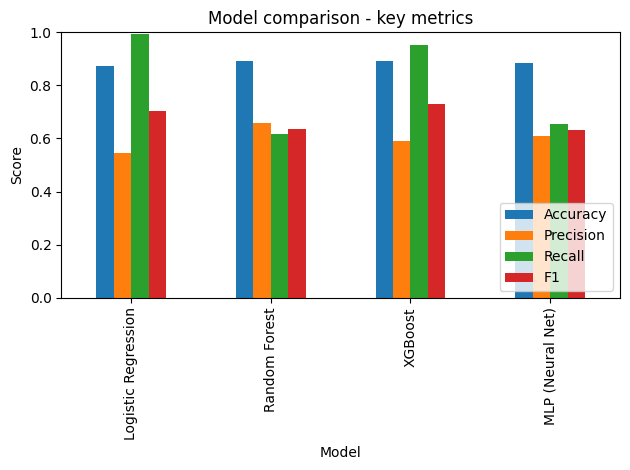

In [11]:
import matplotlib.pyplot as plt

# Plot comparison bar chart for key metrics
plt.figure(figsize=(10,6))
results_df.set_index("Model")[["Accuracy","Precision","Recall","F1"]].plot(kind="bar")
plt.title("Model comparison - key metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("artifacts/plots/models_comparison_metrics.png")
plt.show()
plt.close()

In [ ]:
import os
import joblib
import shap
import lime
import lime.lime_tabular
import seaborn as sns

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

MODEL_SUMMARY_PATH = "artifacts/models_summary.csv"

summary_df = pd.read_csv(MODEL_SUMMARY_PATH)
best_model_name = summary_df.iloc[0]["model"]
model_path = f"artifacts/models/{best_model_name}_best.joblib"
best_model = joblib.load(model_path)

print(f"Loaded best model: {best_model_name}")

# -----------------------------
# SHAP Explainability
# -----------------------------
print("\n=== SHAP Explainability ===")
explainer = shap.TreeExplainer(best_model.named_steps['clf'])
shap_values = explainer.shap_values(X_test)

# SHAP summary plot (feature importance)
plt.title(f"SHAP Summary ({best_model_name})")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig(f"artifacts/plots/{best_model_name}_shap_summary.png")
plt.close()

# SHAP bar plot (mean absolute importance)
shap.plots.bar(shap_values, show=True)
plt.title(f"SHAP Mean Abs Importance ({best_model_name})")
plt.tight_layout()
plt.savefig(f"artifacts/plots/{best_model_name}_shap_bar.png")
plt.close()

# Individual SHAP force plot (first instance)
shap.initjs()
force_plot_path = f"artifacts/plots/{best_model_name}_shap_force.html"

# Robustly handle expected_value and shap_values shape
if hasattr(explainer, "expected_value") and isinstance(explainer.expected_value, (list, np.ndarray)):
    if np.ndim(explainer.expected_value) == 0 or (np.ndim(explainer.expected_value) == 1 and len(explainer.expected_value) == 1):
        expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:
        expected_value = explainer.expected_value[0]
else:
    expected_value = explainer.expected_value

# For shap_values.values, handle shape (may be [n_samples, n_features] or [n_samples, n_features, n_classes])
if hasattr(shap_values, "values"):
    if shap_values.values.ndim == 3:
        # [n_samples, n_features, n_classes]
        shap_val = shap_values.values[0,:,1] if shap_values.values.shape[2] > 1 else shap_values.values[0,:,0]
    elif shap_values.values.ndim == 2:
        shap_val = shap_values.values[0]
    else:
        shap_val = shap_values.values
else:
    shap_val = shap_values[0]

shap.save_html(force_plot_path, shap.force_plot(expected_value, shap_val, X_sample.iloc[0,:]))

print("SHAP plots saved.")

# -----------------------------
# Permutation Importance
# -----------------------------
print("\n=== Permutation Importance ===")
perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.DataFrame({
    "Feature": X_test.columns,
    "ImportanceMean": perm.importances_mean,
    "ImportanceStd": perm.importances_std
}).sort_values(by="ImportanceMean", ascending=False)

perm_importances.to_csv(f"artifacts/{best_model_name}_perm_importance.csv", index=False)

plt.figure(figsize=(8,6))
sns.barplot(x="ImportanceMean", y="Feature", data=perm_importances.head(15))
plt.title(f"Permutation Feature Importance ({best_model_name})")
plt.tight_layout()
plt.savefig(f"artifacts/plots/{best_model_name}_perm_importance.png")
plt.close()

# -----------------------------
# Partial Dependence Plots
# -----------------------------
print("\n=== Partial Dependence Plots ===")
top_features = perm_importances["Feature"].head(3).tolist()

for feat in top_features:
    fig, ax = plt.subplots(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(best_model, X_test, [feat], ax=ax)
        plt.title(f"Partial Dependence: {feat}")
        plt.tight_layout()
        plt.savefig(f"artifacts/plots/{best_model_name}_pdp_{feat}.png")
        plt.close()
    except Exception as e:
        print(f"Skipping PDP for {feat}: {e}")

print("PDPs saved.")

# -----------------------------
# LIME Explanation (local)
# -----------------------------
print("\n=== LIME Explanation ===")
scaler = StandardScaler().fit(X_train)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaler.transform(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=["No Defect", "Defect"],
    mode="classification"
)

idx = np.random.randint(0, len(X_test))
lime_exp = lime_explainer.explain_instance(
    data_row=scaler.transform([X_test.iloc[idx]])[0],
    predict_fn=lambda x: best_model.predict_proba(scaler.inverse_transform(x))
)

lime_exp.save_to_file(f"artifacts/plots/{best_model_name}_lime_instance.html")
print("LIME explanation saved for one sample instance.")

# -----------------------------
# Real-world insights
# -----------------------------
print("\n=== Real-world Insights ===")
top_feats = perm_importances.head(5)["Feature"].tolist()
print(f"Top influential features: {top_feats}")


c:\Users\ASUS\Lasitha\MSC Data Science\Machine Learning\Lecuture workbooks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
